In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%matplotlib inline

In [19]:
from plotting.constants import (
    BASE_SAVE_DIR,
    PROJECT_NAME_BASE,
    FONTSIZE,
    SAVE_EXTENSION,
)
from plotting.utils import (
    render_in_latex,
    set_fontsize,
    get_save_path,
    get_runs,
    get_metrics_and_colors,
    get_metric_statistics,
    plot_metric_statistics,
)

from matplotlib.patches import FancyArrowPatch
import numpy as np

In [20]:
dataset = "taxi"
metric = "test_rmse"
X_AXIS_NAME = "time"

In [21]:
def _do_plotting_for_metric(datasets: list[str], metric: str):
    """
    Plot the metric for the given datasets.
    """
    statistics_dicts = {}
    size_dict = {}

    for dataset in datasets:
        runs = get_runs(PROJECT_NAME_BASE + dataset, mode="gp_inference")
        metrics_dict, colors_dict = get_metrics_and_colors(runs, metric)
        statistics_dicts[dataset] = get_metric_statistics(metrics_dict)
        size_dict[dataset] = runs[0].run.config["ntr"]

    # Plot the statistics
    fig, axes = plot_metric_statistics(
        statistics_dicts,
        colors_dict,
        X_AXIS_NAME,
        size_dict=size_dict,
        use_min_time=True,
    )
    return fig, axes

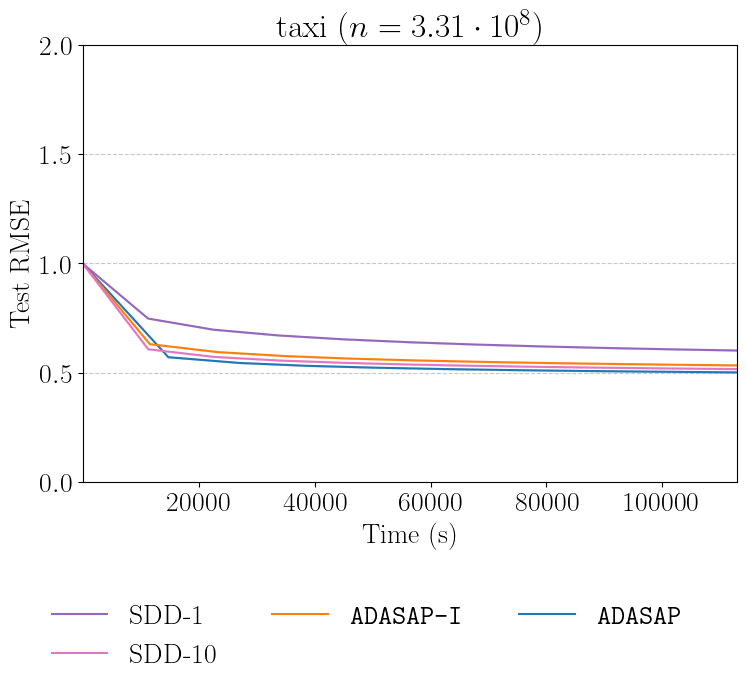

In [22]:
# Set the font size for the plots
set_fontsize(FONTSIZE)

# Render in LaTeX
render_in_latex()

fig, axes = _do_plotting_for_metric([dataset], metric)

In [23]:
axes[0][0].set_ylim(0.4, 1)

(0.4, 1.0)

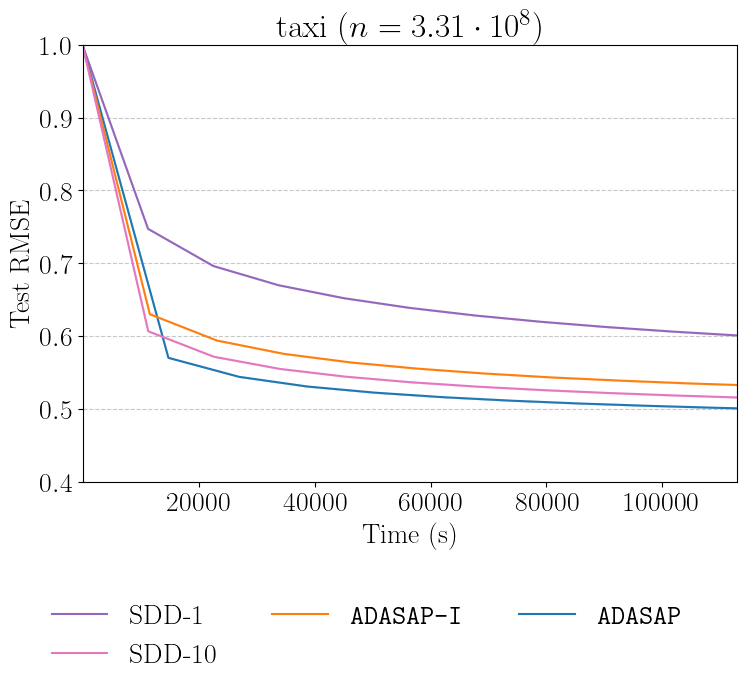

In [24]:
display(fig)

In [25]:
lines = axes[0][0].get_lines()
# Create a list of (line, final_y_value) tuples
lines_with_final_values = []
for line in lines:
    y_data = line.get_ydata()
    final_y = y_data[-1]  # Get the last y-value
    lines_with_final_values.append((line, final_y))

# Sort the lines based on the final y-value (lowest to highest)
sorted_lines = [line for line, _ in sorted(
    lines_with_final_values, key=lambda x: x[1])]

In [26]:
for i, line in enumerate(sorted_lines):
    print(f"Line {i}: {line.get_label()} with final y-value: {line.get_ydata()[-1]}")

Line 0: \texttt{ADASAP} with final y-value: 0.499384343624115
Line 1: SDD-10 with final y-value: 0.515769898891449
Line 2: \texttt{ADASAP-I} with final y-value: 0.5316548347473145
Line 3: SDD-1 with final y-value: 0.6009643077850342


In [27]:
print(sorted_lines[3].get_xdata()[-1])

112928.85891008377


In [28]:
def find_first_crossing(x_data, y_data, threshold):
    """
    Find the x-value where y_data first goes below the threshold.
    Returns None if it never crosses the threshold.
    """
    # Find indices where y is below threshold
    below_threshold_indices = np.where(y_data < threshold)[0]

    if len(below_threshold_indices) == 0:
        return None  # Never crosses threshold

    # Get the first index where y is below threshold
    first_below_idx = below_threshold_indices[0]

    # If it's already below threshold at the first point
    if first_below_idx == 0:
        return x_data[0]

    # Otherwise, interpolate between the points to find more precise crossing
    x_before = x_data[first_below_idx - 1]
    y_before = y_data[first_below_idx - 1]
    x_after = x_data[first_below_idx]
    y_after = y_data[first_below_idx]

    # Linear interpolation to find crossing point
    if y_before == y_after:  # Avoid division by zero
        return x_before

    # Calculate the x value where y crosses the threshold
    x_crossing = x_before + (threshold - y_before) * \
        (x_after - x_before) / (y_after - y_before)

    return x_crossing

In [29]:
best_line = sorted_lines[0]
second_best_line = sorted_lines[1]

crossing_point = find_first_crossing(
    best_line.get_xdata(),
    best_line.get_ydata(),
    second_best_line.get_ydata()[-1]
)
print(f"Crossing point: {crossing_point}")

Crossing point: 63216.68536928625


In [30]:
# Add a horizontal arrow at the y-value of the second best line starting at the
# the end of the x-axis and ending at the crossing point

# Get the y-value and x-coordinates
y_value = second_best_line.get_ydata()[-1]
x_end = axes[0][0].get_xlim()[1]

# Create an arrow
arrow = FancyArrowPatch(
    posA=(crossing_point, y_value),# Start point (left)
    posB=(x_end, y_value),         # End point (right)
    arrowstyle='<|-|>',            # Line with arrow at the left end
    color='k',                     # Black color
    linewidth=1.5,                 # Line width
    linestyle='--',                # Dashed line style
    mutation_scale=15,              # Controls arrow size
    shrinkA=0, shrinkB=0,           # Don't shrink from the exact positions
    zorder=10,                       # Higher zorder value to be on top
)

# Add the arrow to the plot
axes[0][0].add_patch(arrow)

# Add annotation below
vertical_offset = (axes[0][0].get_ylim()[1] - axes[0][0].get_ylim()[0]) * 0.03
text = axes[0][0].text(
    (crossing_point + x_end) / 2,  # x position - middle of line
    y_value - vertical_offset,     # y position - below line
    f"{x_end / crossing_point:.1f}" + r"$\times$" + " speedup",
    ha='center',
    va='top',
    fontsize=FONTSIZE,
    zorder=10,
)

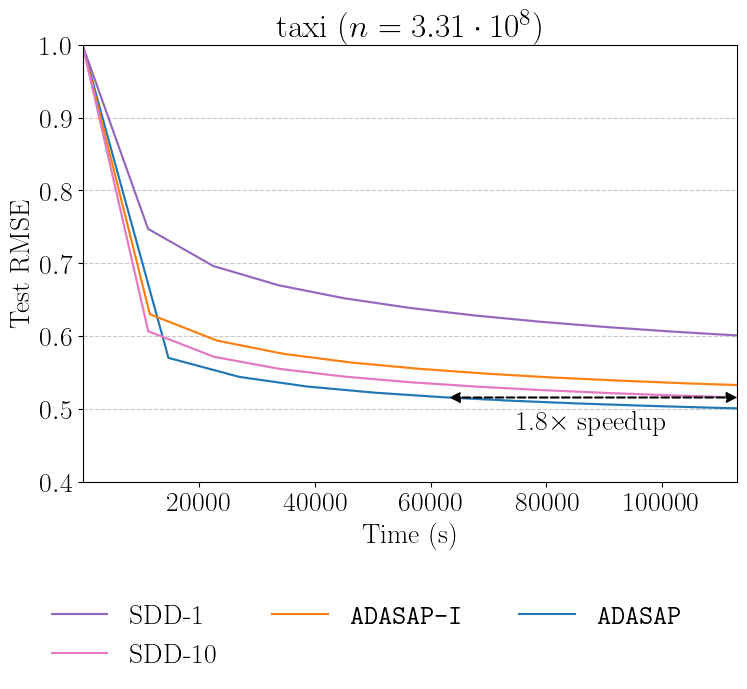

In [31]:
display(fig)

In [32]:
save_path = get_save_path(f"../{BASE_SAVE_DIR}/gp_inf/{dataset}",
                          f"{metric}_{X_AXIS_NAME}_annotated.{SAVE_EXTENSION}")
fig.savefig(save_path)